In [106]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [107]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import FeatureUnion, Pipeline 
from joblib import dump,load
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt


In [109]:
df_h1b = pd.read_csv('data/h1b_kaggle.csv', sep=',')
df_h1b.head(5)
df_h1b.shape

(3002458, 11)

In [110]:
df = df_h1b.drop(df_h1b.columns[0], axis='columns')

In [111]:
#Dropping the latitude and longitude columns 
df.drop(['lon','lat'], axis=1, inplace=True)

In [112]:
#making multivariate classification into binary classification for case status column (target)
warnings.filterwarnings("ignore")
df.CASE_STATUS[df['CASE_STATUS']=='REJECTED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='INVALIDATED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='CERTIFIED-WITHDRAWN'] = 'CERTIFIED'

In [113]:
df = df.drop(df[df.CASE_STATUS == 'WITHDRAWN'].index)

In [114]:
## Storing non null in df w.r.t. case status
df = df[df['CASE_STATUS'].notnull()]
print(df['CASE_STATUS'].value_counts())


CERTIFIED    2818282
DENIED         94364
Name: CASE_STATUS, dtype: int64


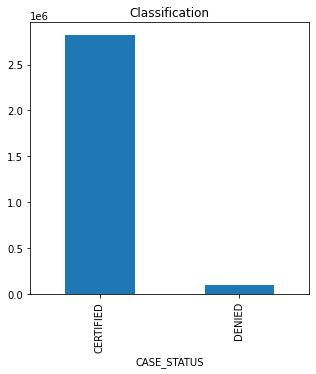

In [115]:
df.groupby('CASE_STATUS').size().plot(kind = 'bar', figsize = (5,5), title = "Classification");

In [116]:
#replacing employer name,  job title, full time and soc name with mode 
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].fillna(df['EMPLOYER_NAME'].mode()[0])
df['JOB_TITLE'] = df['JOB_TITLE'].fillna(df['JOB_TITLE'].mode()[0])
df['FULL_TIME_POSITION'] = df['FULL_TIME_POSITION'].fillna(df['FULL_TIME_POSITION'].mode()[0])
df['SOC_NAME'] = df['SOC_NAME'].fillna(df['SOC_NAME'].mode()[0])

In [117]:
#converting worksite and extracting only the state from it
df['STATE'] = df.WORKSITE.str.split(',').str[-1]

In [118]:
df.drop(['WORKSITE'], axis=1, inplace=True)

In [119]:
#Dropping all rows with missing Prevailing Wage values 
df.dropna(inplace = True)

In [120]:
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].str.lower()

In [121]:
#Dropping JOB_TITLE as it has over 200000 
df.drop(['JOB_TITLE'], axis=1, inplace=True)

In [19]:
#top 10 employers
top_ten_emp = df.groupby(['EMPLOYER_NAME']).size().sort_values(ascending = False).head(10)

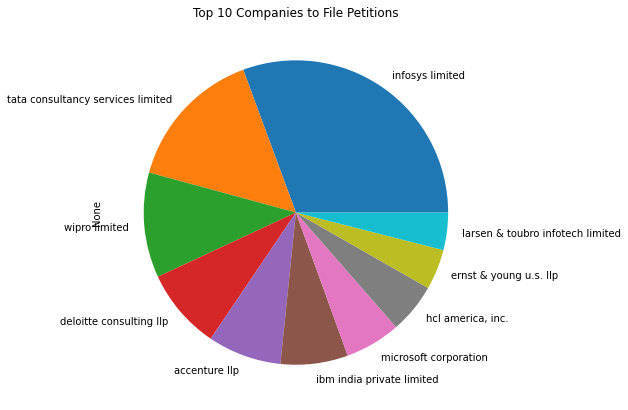

In [20]:
#plotting the top 10 employers
top_ten_emp.plot(kind = 'pie', figsize = (50,7), title = "Top 10 Companies to File Petitions"); 

In [21]:
#Adding a new employer column : replacing top 10 employers and all others as 'others'
df['NEW_EMPLOYER'] = np.nan
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('infosys limited')] = 'infosys limited'
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('tata consultancy services limited')] = 'tata consultancy services limited'
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('wipro limited')] = 'wipro limited'
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('deloitte consulting llp')] = 'deloitte consulting llp'
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('ibm india private limited')] = 'ibm india private limited'
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('accenture llp')] = 'accenture llp'
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('microsoft corporation')] = 'microsoft corporation'
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('hcl america, inc')] = 'hcl america, inc'
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('ernst & young u.s. llp')] = 'ernst & young u.s. llp'
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('cognizant technology solutions u.s. corporation')] = 'cognizant technology solutions u.s. corporation'
df['NEW_EMPLOYER']= df.NEW_EMPLOYER.replace(np.nan, 'others', regex=True)

In [122]:
#top 10 states
top_ten_states = df.groupby(['STATE']).size().sort_values(ascending = False).head(10)

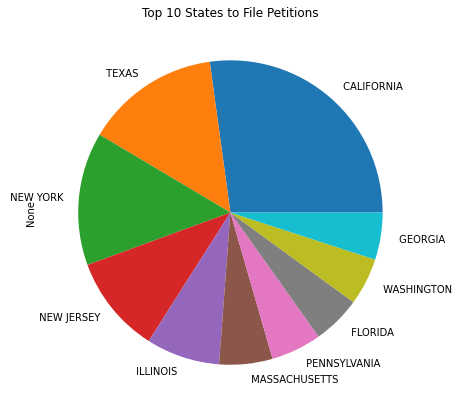

In [123]:
#plotting the top 10 states
top_ten_states.plot(kind = 'pie', figsize = (50,7), title = "Top 10 States to File Petitions");

In [124]:
df.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,STATE
0,CERTIFIED,university of michigan,BIOCHEMISTS AND BIOPHYSICISTS,N,36067.0,2016.0,MICHIGAN
1,CERTIFIED,"goodman networks, inc.",CHIEF EXECUTIVES,Y,242674.0,2016.0,TEXAS
2,CERTIFIED,"ports america group, inc.",CHIEF EXECUTIVES,Y,193066.0,2016.0,NEW JERSEY
3,CERTIFIED,"gates corporation, a wholly-owned subsidiary o...",CHIEF EXECUTIVES,Y,220314.0,2016.0,COLORADO
5,CERTIFIED,burger king corporation,CHIEF EXECUTIVES,Y,225000.0,2016.0,FLORIDA


In [125]:
classes_per_year = df.groupby(['YEAR', 'CASE_STATUS'])

In [126]:
#see how many cases have been certified and denied over the years 
classes_per_year.size()

YEAR    CASE_STATUS
2011.0  CERTIFIED      319532
        DENIED          29125
2012.0  CERTIFIED      383786
        DENIED          21074
2013.0  CERTIFIED      418383
        DENIED          12135
2014.0  CERTIFIED      491494
        DENIED          11887
2015.0  CERTIFIED      588349
        DENIED          10916
2016.0  CERTIFIED      616738
        DENIED           9174
dtype: int64

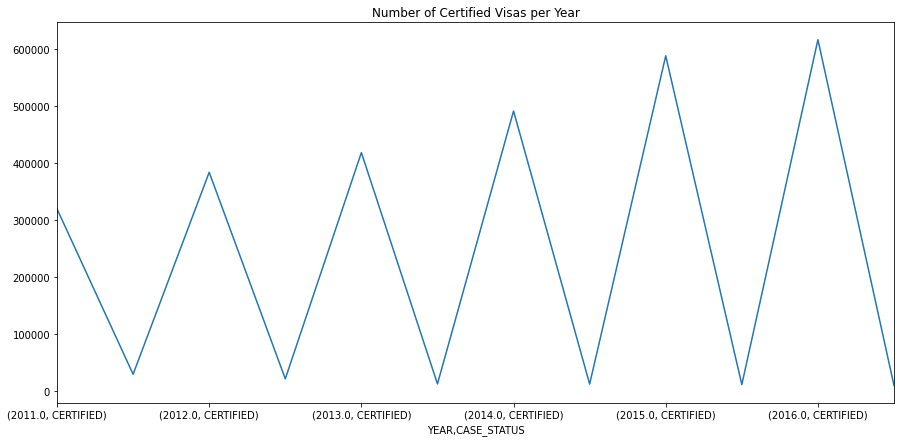

In [127]:
classes_per_year.size().plot(kind = 'line', figsize = (15,7), title = "Number of Certified Visas per Year");
#as we observe, this progressively increases

##### Understanding Prevailing Wage associated with Occupation

In [142]:
# Top 10 occupations with the highest median wages. Using median as the data is very skewed with many outliers
# The plot shows the that Out of the top 10 high income occupations, 8 are in the medical and health care field. 

soc_wage = df.groupby(['SOC_NAME'], as_index=False)['PREVAILING_WAGE'].aggregate(np.median).sort_values(by=['PREVAILING_WAGE'],ascending=False)
soc_wage =soc_wage.head(10)
soc_wage.iloc[0]

SOC_NAME           HELPERS, CONSTRUCTION TRADES, ALL OTHER
PREVAILING_WAGE                                 8.6528e+07
Name: 1024, dtype: object

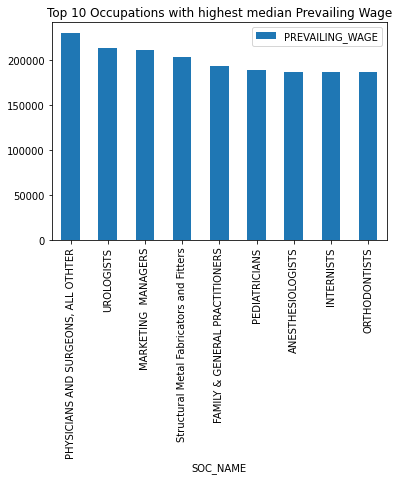

In [143]:
soc_wage[1:10].plot(kind='bar',x='SOC_NAME',y='PREVAILING_WAGE', title='Top 10 Occupations with highest median Prevailing Wage');

In [28]:
df['OCCUPATION'] = np.nan
df['SOC_NAME'] = df['SOC_NAME'].str.lower()
df.OCCUPATION[df['SOC_NAME'].str.contains('computer','programmer')] = 'computer and mathematical occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('software','web developer')] = 'computer and mathematical occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('database')] = 'computer and mathematical occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('math','statistic')] = 'computer and mathematical occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('predictive model','stats')] = 'computer and mathematical occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('teacher','linguist')] = ' educational instruction and library occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('professor','Teach')] = 'educational instruction and library occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('school principal')] = 'educational instruction and library occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('medical','doctor')] = 'medical or healthcare support occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('physician','dentist')] = 'medical or healthcare support occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('Health','Physical Therapists')] = 'medical or healthcare support occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('surgeon','nurse')] = 'medical or healthcare support occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('psychiatr')] = 'medical or healthcare support occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('chemist','physicist')] = 'advanced sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('biology','scientist')] = 'advanced sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('biologi','clinical research')] = 'advanced sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('public relation','manage')] = 'management occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('management','operation')] = 'management occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('chief','plan')] = 'management occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('executive')] = 'management occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('advertis','marketing')] = 'marketing occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('promotion','market research')] = 'marketing occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('business','business analyst')] = 'business and financial occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('business systems analyst')] = 'business and financial occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('accountant','finance')] = 'business and financial occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('financial')] = 'business and financial occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('engineer','architect')] = 'architecture and engineering occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('surveyor','carto')] = 'architecture and engineering occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('technician','drafter')] = 'architecture and engineering occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('information security','information tech')] = 'architecture and engineering occupations'
df['OCCUPATION']= df.OCCUPATION.replace(np.nan, 'others', regex=True)

In [29]:
occ_group = df.groupby('OCCUPATION').size().sort_values(ascending = False)

In [30]:
occ_group

OCCUPATION
computer and mathematical occupations               1740138
others                                               440302
architecture and engineering occupations             305992
business and financial occupations                   142953
management occupations                                78543
medical or healthcare support occupations             73348
 educational instruction and library occupations      70953
advanced sciences                                     57345
marketing occupations                                  3019
dtype: int64

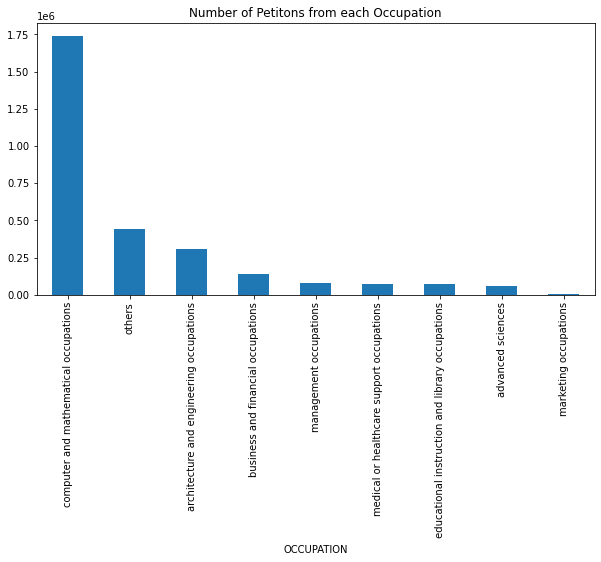

In [31]:
occ_group.plot(kind='bar', figsize = (10,5),title = "Number of Petitons from each Occupation");

In [32]:
## capping prevailing wage to get rid of outliers and spiking data points
df.loc[df.PREVAILING_WAGE < 34029, 'PREVAILING_WAGE']= 34029
df.loc[df['PREVAILING_WAGE'] > 138703, 'PREVAILING_WAGE']= 138703

In [33]:
#dropping SOC_NAME and YEAR 
df.drop(['SOC_NAME'], axis=1, inplace= True)
df.drop(['YEAR'], axis=1, inplace= True)
df.drop(['EMPLOYER_NAME'], axis=1, inplace= True)


In [34]:
#labelling categorical variables as 'category' datatype 
df[['FULL_TIME_POSITION','NEW_EMPLOYER','OCCUPATION','STATE']] = df[['FULL_TIME_POSITION','NEW_EMPLOYER','OCCUPATION','STATE']].apply(lambda x: x.astype('category'))

### TRYING DIFFERENT PIVOT TABLES

In [35]:
df.head()

,CASE_STATUS,FULL_TIME_POSITION,PREVAILING_WAGE,STATE,NEW_EMPLOYER,OCCUPATION
0,CERTIFIED,N,36067.0,MICHIGAN,others,advanced sciences
1,CERTIFIED,Y,138703.0,TEXAS,others,management occupations
2,CERTIFIED,Y,138703.0,NEW JERSEY,others,management occupations
3,CERTIFIED,Y,138703.0,COLORADO,others,management occupations
5,CERTIFIED,Y,138703.0,FLORIDA,others,management occupations


In [36]:
pt1 = pd.pivot_table(df, index = ["STATE", "CASE_STATUS"])

In [37]:
pt1

PREVAILING_WAGE
STATE                 CASE_STATUS                 
 ALABAMA              CERTIFIED       61645.127042
                      DENIED          68168.607050
 ALASKA               CERTIFIED       68114.576647
                      DENIED          62483.900000
 ARIZONA              CERTIFIED       66304.404122
                      DENIED          63052.998443
 ARKANSAS             CERTIFIED       58080.761804
                      DENIED          62614.689069
 CALIFORNIA           CERTIFIED       81637.684571
                      DENIED          71694.530261
 COLORADO             CERTIFIED       68890.936509
                      DENIED          68815.592476
 CONNECTICUT          CERTIFIED       70849.183673
                      DENIED          69458.752605
 DELAWARE             CERTIFIED       68372.970048
                      DENIED          67986.117711
 DISTRICT OF COLUMBIA CERTIFIED       69627.436732
                      DENIED          66023.628195
 FLORIDA              CERTIFIED       61559.126498
                      DENIED          58792.770077
 GEORGIA              CERTIFIED       64525.906520
                      DENIED          63793.104719
 HAWAII               CERTIFIED       58716.257487
                      DENIED          60174.086375
 IDAHO                CERTIFIED       63113.643486
                      DENIED          66238.685567
 ILLINOIS             CERTIFIED       64268.457045
                      DENIED          64490.660647
 INDIANA              CERTIFIED       61153.048779
                      DENIED          65226.473950
 IOWA                 CERTIFIED       63187.938212
                      DENIED          65233.370571
 KANSAS               CERTIFIED       61265.291598
                      DENIED          62334.723264
 KENTUCKY             CERTIFIED       61974.241233
                      DENIED          66861.984579
 LOUISIANA            CERTIFIED       57679.582092
                      DENIED          58682.889126
 MAINE                CERTIFIED       69668.700903
                      DENIED          74124.383824
 MARYLAND             CERTIFIED       66414.839623
                      DENIED          65027.026326
 MASSACHUSETTS        CERTIFIED       71442.810039
                      DENIED          69664.754163
 MICHIGAN             CERTIFIED       64326.316288
                      DENIED          64327.497299
 MINNESOTA            CERTIFIED       67058.384496
                      DENIED          69705.385214
 MISSISSIPPI          CERTIFIED       59630.522041
                      DENIED          61267.372734
 MISSOURI             CERTIFIED       63797.001639
                      DENIED          64898.215167
 MONTANA              CERTIFIED       57910.443599
                      DENIED          61103.159524
 NA                   CERTIFIED       47133.870507
                      DENIED          45304.986758
 NEBRASKA             CERTIFIED       62400.878440
                      DENIED          68291.080996
 NEVADA               CERTIFIED       66755.343146
                      DENIED          65239.794793
 NEW HAMPSHIRE        CERTIFIED       68094.708341
                      DENIED          72214.608889
 NEW JERSEY           CERTIFIED       68203.245401
                      DENIED          68405.065486
 NEW MEXICO           CERTIFIED       64807.919327
                      DENIED          60082.441313
 NEW YORK             CERTIFIED       72220.164540
                      DENIED          65583.705928
 NORTH CAROLINA       CERTIFIED       67342.820045
                      DENIED          65163.272643
 NORTH DAKOTA         CERTIFIED       65857.978462
                      DENIED          69466.636414
 OHIO                 CERTIFIED       63320.545257
                      DENIED          65089.098632
 OKLAHOMA             CERTIFIED       56144.968359
                      DENIED          55198.251064
 OREGON               CERTIFIED       72480.310153
      

In [90]:
##### Data Visualization for FULL_TIME_POSITION Feature

In [89]:
full_time = df.groupby('FULL_TIME_POSITION').size().to_frame('size').reset_index()
full_time['percentage'] = np.nan
sum = full_time['size'].sum()
full_time['percentage'] = (full_time['size']/sum)

full_time.drop(['size'], axis=1, inplace= True)

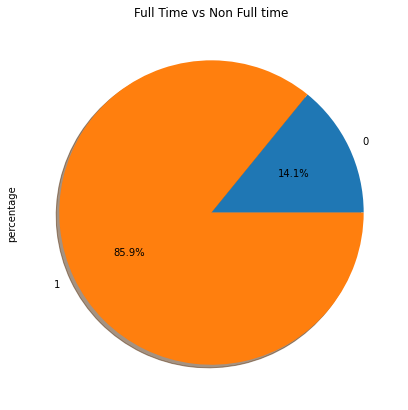

In [77]:
plot = full_time.plot.pie(y='percentage',title="Full Time vs Non Full time", legend=False, \
                   autopct='%1.1f%%', \
                   shadow=True, startangle=0, figsize=(7, 7))


#### Prevailing Wage for the top 10 Employers

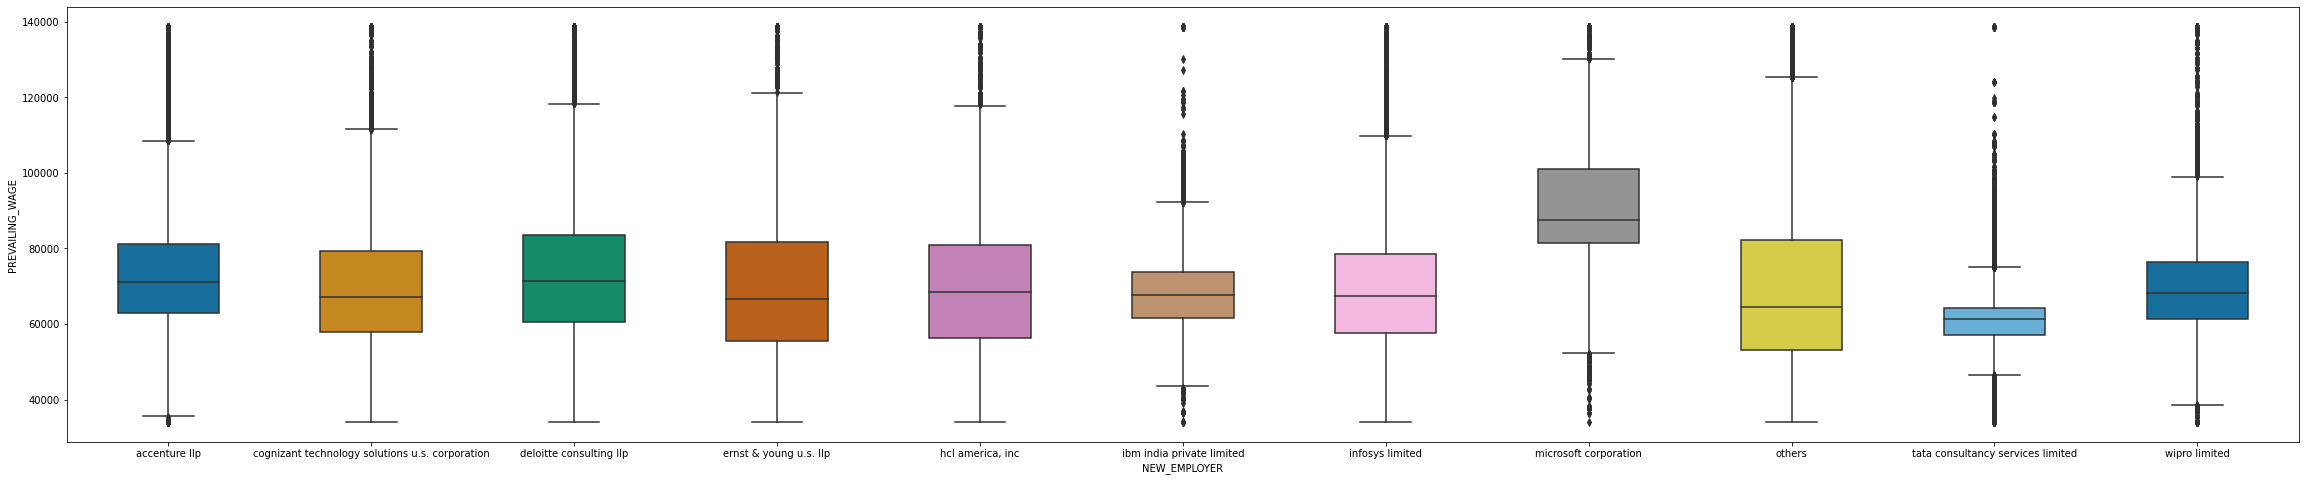

In [88]:
a4_dims = (40, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.boxplot(y='PREVAILING_WAGE', x='NEW_EMPLOYER', 
                 data=df, 
                 width=0.5,
                 palette="colorblind");

From the boxplot we can see that the median wage of Microsoft exceed all the other major companies.